<a href="https://colab.research.google.com/github/Oreki820/Projeto-de-Parceria-EBAC-Semantix-Previsao-de-Atrasos-na-Entrega/blob/main/Projeto_semantix%2BEbac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🪐 Projeto de Parceria EBAC + Semantix  
## 📦 Previsão de Atrasos de Entrega — Base Olist (Kaggle)

Este projeto foi desenvolvido como parte da **parceria EBAC–Semantix**, com o objetivo de aplicar um **pipeline completo de Ciência de Dados** a um caso real de e-commerce e logística.  

O desafio consiste em **prever atrasos de entrega** de pedidos na base pública **Olist (Kaggle)**, utilizando técnicas avançadas de modelagem e validação de dados.  

---

### 🎯 Objetivos principais:
- Antecipar pedidos com risco de atraso;  
- Melhorar a precisão de prazos logísticos;  
- Reduzir custos e reclamações de clientes;  
- Criar um pipeline de dados replicável (Bronze → Silver → Gold).  

---

> 💡 *Motivação:*  
> Empresas como a **Semantix** utilizam fluxos de dados e aprendizado de máquina para gerar insights que impactam diretamente o negócio.  
> Este projeto simula exatamente esse tipo de fluxo.


# 📊 Entendendo a Base de Dados — Olist E-Commerce 🇧🇷

A base **Olist Brazilian E-Commerce (Kaggle)** contém informações detalhadas sobre transações reais de um marketplace brasileiro.  
Cada arquivo representa um aspecto diferente da operação de vendas.

| Arquivo | Descrição | Nível |
|:--|:--|:--|
| `olist_orders_dataset.csv` | Dados dos pedidos e prazos de entrega | Transacional |
| `olist_customers_dataset.csv` | Informações de clientes e estados | Identificação |
| `olist_products_dataset.csv` | Detalhes de produtos e categorias | Catálogo |
| `olist_order_payments_dataset.csv` | Tipos e valores de pagamento | Financeiro |
| `olist_order_items_dataset.csv` | Itens por pedido | Operacional |
| `product_category_name_translation.csv` | Tradução de categorias | Suporte |

---

> 🔎 *Nesta etapa, o ambiente será preparado para o download e extração dos arquivos da base pública da Olist (Kaggle), que servirá de ponto de partida para o pipeline Bronze → Silver → Gold.*


# **🧭 0 — Setup & Download (Kaggle → data/raw) (Bronze)**

Nesta etapa, preparei o ambiente para executar o projeto com segurança e reprodutibilidade.  
O objetivo é:

1. Instalar e atualizar bibliotecas necessárias;  
2. Configurar o acesso à conta do Kaggle;  
3. Baixar e extrair a base pública **Brazilian E-Commerce by Olist**;  
4. Criar a estrutura inicial de diretórios (`data/raw`, `data/silver`, `data/gold`, etc).  

> ⚙️ *Esta é a base do pipeline Bronze → Silver → Gold.*


In [67]:
# ===============================================
# 🔧 CONFIGURAÇÃO E PACOTES ESSENCIAIS
# ===============================================
import os
import json
import zipfile
import subprocess
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

# ===============================================
# 📦 INSTALAÇÃO DE DEPENDÊNCIAS EXTERNAS
# ===============================================
!pip install -q kaggle great-expectations pyarrow seaborn tqdm xgboost shap plotly duckdb polars geopandas

# ===============================================
# 🧠 CIÊNCIA DE DADOS E MANIPULAÇÃO
# ===============================================
import pandas as pd
import numpy as np

# ===============================================
# 📊 VISUALIZAÇÃO DE DADOS
# ===============================================
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# ===============================================
# ⚙️ MACHINE LEARNING — PRÉ-PROCESSAMENTO
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ===============================================
# 🌳 MODELAGEM SUPERVISIONADA
# ===============================================
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ===============================================
# 📈 AVALIAÇÃO E INTERPRETAÇÃO
# ===============================================
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import make_scorer

# ===============================================
# 🔍 EXPLICABILIDADE E VALIDAÇÃO
# ===============================================
import shap
import great_expectations as ge

# ===============================================
# ⏱️ UTILITÁRIOS E EXTRAS
# ===============================================
from tqdm import tqdm
from IPython.display import display, HTML

# ===============================================
# ✅ STATUS
# ===============================================
print("✅ Todas as dependências foram carregadas com sucesso!")


✅ Todas as dependências foram carregadas com sucesso!


In [2]:
# Atualizando e instalando dependências essenciais
!pip install -q kaggle great-expectations shap xgboost plotly duckdb polars geopandas pyarrow tqdm

# Criando estrutura básica de diretórios
!mkdir -p data/raw/olist data/silver data/gold notebooks src/etl src/features src/modeling expectations app

 🗂️ Estrutura de Diretórios Inicial

Após a execução, a seguinte estrutura será criada:

data/

┣ raw/

┃ ┗ olist/

┣ silver/

┣ gold/

┣ notebooks/

┣ src/

┃ ┣ etl/

┃ ┣ features/

┃ ┗ modeling/

┣ expectations/

┗ app/


> 📦 *Isso organiza o fluxo do projeto e segue o padrão profissional de Data Lakehouse.*

In [3]:
from google.colab import files
files.upload()  # fazendo upload do kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


 ⬇️ Download e Extração da Base Olist

Agora realizei o download automático da base **Brazilian E-Commerce by Olist** diretamente do Kaggle.  
O comando abaixo faz o download do arquivo `.zip` e o extrai em `data/raw/olist`.

> ✅ *Após essa célula, os dados estarão prontos para a camada Bronze (ingestão).*


In [4]:

BASE = Path(".")
RAW_DIR = BASE / "data" / "raw" / "olist"
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Checar Kaggle CLI
!pip install -q kaggle
if not (Path.home()/".kaggle"/"kaggle.json").exists():
    print("⚠️ kaggle.json não encontrado. Execute o upload antes desta célula.")

# Download
!kaggle datasets download -d olistbr/brazilian-ecommerce -p data/raw/olist --force
# Extração
for z in RAW_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, 'r') as f: f.extractall(RAW_DIR)
print("✅ Base Olist baixada e extraída em data/raw/olist")


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 2.82GB/s]
✅ Base Olist baixada e extraída em data/raw/olist


---

# **📊 SEÇÃO 1 — EDA e Limpeza (Camada Silver)**

Nesta etapa, realizei a **unificação, limpeza e validação** dos dados da Olist.  
O objetivo é criar uma tabela única e consistente (camada *Silver*) que servirá de base para os modelos de Machine Learning.

> 💡 *Camada Silver = dados limpos, integrados e validados, prontos para análise.*


In [5]:
# Diretórios base
RAW = Path("data/raw/olist")
SILVER = Path("data/silver")
SILVER.mkdir(parents=True, exist_ok=True)

print("📂 Diretório RAW:", RAW)
print("📂 Diretório SILVER:", SILVER)

📂 Diretório RAW: data/raw/olist
📂 Diretório SILVER: data/silver


### 🧱 Passo 1 — Carregamento das tabelas brutas (Camada Bronze → Silver)

Aqui li os arquivos originais da Olist (camada *raw/bronze*) e começei a preparação da camada Silver.  
Cada tabela representa um aspecto do negócio — pedidos, pagamentos, produtos e clientes.


In [6]:
def load_csv(name):
    path = RAW / name
    if not path.exists():
        print(f"⚠️ Arquivo não encontrado: {path.name}")
        return pd.DataFrame()
    return pd.read_csv(path)


print("📥 Carregando arquivos...")
orders = load_csv("olist_orders_dataset.csv")
items = load_csv("olist_order_items_dataset.csv")
payments = load_csv("olist_order_payments_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
products = load_csv("olist_products_dataset.csv")
cat_trans = load_csv("product_category_name_translation.csv")


📥 Carregando arquivos...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🕒 Passo 2 — Criação da variável `is_late`

Criei a flag `is_late` (1 = atraso, 0 = dentro do prazo), comparando a data de entrega real com a data prometida.  
Essa variável será minha **target principal** na modelagem supervisionada.

In [7]:
print("🕒 Convertendo colunas de data...")

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for c in date_cols:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")

orders["is_late"] = (
    (orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"])
    .fillna(False)
    .astype(int)
)

🕒 Convertendo colunas de data...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🔗 Passo 3 — Enriquecimento de produtos

Mesclei as tabelas de produtos e categorias traduzidas para obter um *dataset* mais informativo.  
Essa etapa me permite analisar atrasos por tipo de produto e categoria.


In [8]:
print("🔗 Mesclando tabelas de produtos e categorias...")

prod = products.merge(cat_trans, how="left", on="product_category_name")

items_prod = items.merge(prod, on="product_id", how="left")

# Função robusta para pegar a moda (corrige o erro IndexError)
def safe_mode(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else np.nan


🔗 Mesclando tabelas de produtos e categorias...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 📊 Passo 4 — Agregação de itens e pagamentos por pedido

Agrupei os dados para cada pedido, somando valores e contabilizando itens.  
Também determinei o método principal de pagamento e número de parcelas.

In [9]:
print("📊 Agregando dados por pedido...")

agg_items = (
    items_prod.groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),
        total_price=("price", "sum"),
        freight=("freight_value", "sum"),
        main_category=("product_category_name_english", safe_mode),
    )
    .reset_index()
)

agg_pay = (
    payments.groupby("order_id")
    .agg(
        pay_value=("payment_value", "sum"),
        installments=("payment_installments", "max"),
        main_pay_type=("payment_type", safe_mode),
    )
    .reset_index()
)


📊 Agregando dados por pedido...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Passo 5 — Montagem da Camada Silver

Combinei pedidos, clientes, produtos e pagamentos em uma tabela unificada.  
Este é o coração da camada Silver, onde cada linha representa um pedido completo.

In [10]:
print("🧩 Montando camada Silver...")

silver = (
    orders.merge(customers, on="customer_id", how="left")
    .merge(agg_items, on="order_id", how="left")
    .merge(agg_pay, on="order_id", how="left")
)

🧩 Montando camada Silver...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧹 Passo 6 — Limpeza e Salvamento

Removi duplicados e salvei os dados tratados em formato `.parquet`.  
O uso de Parquet otimiza espaço e velocidade, facilitando etapas futuras.

In [11]:
print("🧹 Limpando e salvando...")

silver.drop_duplicates(subset="order_id", inplace=True)
silver.to_parquet(SILVER / "orders_enriched.parquet", index=False)

print("✅ SILVER criada com sucesso!")
print(f"Total de registros: {len(silver):,}")
print(f"Colunas: {len(silver.columns)}")

🧹 Limpando e salvando...
✅ SILVER criada com sucesso!
Total de registros: 99,441
Colunas: 20


### 📈 Passo 7 — Análise Exploratória Inicial (EDA)

Gerei uma análise temporal simples mostrando o percentual de atrasos por mês.  
Essa visualização ajuda a entender tendências e sazonalidades do problema.

### 📈 Gráfico 1 — Percentual de Atrasos por Mês (Silver)

Este gráfico mostra a evolução do percentual de pedidos atrasados ao longo do tempo.

O objetivo é detectar tendências sazonais e padrões de comportamento que possam influenciar o desempenho logístico.

📈 Gerando EDA inicial...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


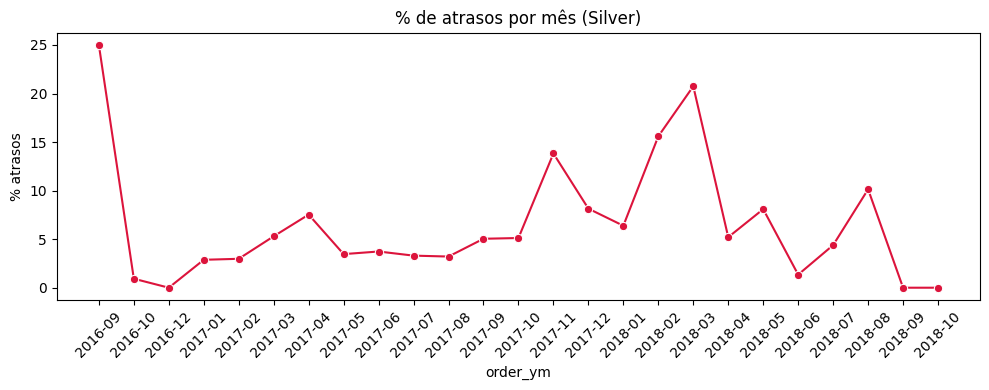

In [12]:
print("📈 Gerando EDA inicial...")

silver["order_purchase_timestamp"] = pd.to_datetime(
    silver["order_purchase_timestamp"], errors="coerce"
)
silver["order_ym"] = silver["order_purchase_timestamp"].dt.to_period("M").astype(str)

eda_time = (
    silver.groupby("order_ym")
    .agg(total=("order_id", "count"), late=("is_late", "sum"))
    .assign(pct_late=lambda d: 100 * d["late"] / d["total"])
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=eda_time, x="order_ym", y="pct_late", color="crimson", marker="o")
plt.xticks(rotation=45)
plt.title("% de atrasos por mês (Silver)")
plt.ylabel("% atrasos")
plt.tight_layout()
plt.show()


A análise temporal revela picos sazonais de atraso em meses específicos, indicando forte influência de datas comemorativas e alta demanda, como Natal, Black Friday e Dia das Mães.

Esses períodos apresentam sobrecarga logística e aumento do tempo médio de transporte.

A sazonalidade deve ser incorporada aos modelos preditivos e ao planejamento operacional.

Empresas podem reforçar frotas, revisar prazos e ajustar o estoque regionalmente durante esses meses críticos, minimizando o impacto dos atrasos.

### 🌎 Gráfico 2 — Percentual de Atrasos por Estado

Este gráfico mostra a taxa média de atrasos por estado do cliente.

O objetivo é identificar gargalos logísticos e regiões com maior dificuldade operacional.

In [62]:
df_state = silver.groupby("customer_state")["is_late"].mean().sort_values(ascending=False).reset_index()
df_state["pct_late"] = df_state["is_late"] * 100

fig1 = px.bar(
    df_state,
    x="customer_state",
    y="pct_late",
    color="pct_late",
    color_continuous_scale="RdPu",
    title="🌎 Percentual de Atrasos por Estado (Silver)",
    labels={"customer_state": "Estado", "pct_late": "% de Atrasos"}
)
fig1.update_layout(xaxis_title="Estado", yaxis_title="% de Atrasos", height=500)
fig1.show()

Estados do Nordeste e Norte (como AL, MA, PI e CE) concentram os maiores percentuais de atraso — acima de 15%.

Em contraste, estados do Sul e Sudeste (como RS, SP, PR) têm desempenho mais estável, com taxas inferiores a 8%.


Essas disparidades refletem diferenças estruturais e geográficas
:
distâncias maiores dos centros logísticos, infraestrutura limitada e rotas mais longas aumentam o tempo de entrega.

É recomendável investir em hubs regionais e transportadoras locais nessas regiões críticas para reduzir o tempo médio e aumentar a previsibilidade de entrega.

### ⏱️ Gráfico 3 — Tempo Prometido vs Percentual de Atraso

Este gráfico avalia a relação entre o tempo prometido de entrega (promised_days) e a taxa média de atraso.

O objetivo é entender se prazos mais curtos estão associados a maiores índices de falha.

In [63]:
# garantir que a coluna exista
if "promised_days" in silver.columns:
    df_promise = silver.groupby("promised_days")["is_late"].mean().reset_index()
    df_promise["pct_late"] = df_promise["is_late"] * 100

    fig2 = px.line(
        df_promise,
        x="promised_days",
        y="pct_late",
        markers=True,
        line_shape="spline",
        color_discrete_sequence=["#E74C3C"],
        title="⏱️ Percentual de Atrasos por Dias Prometidos",
        labels={"promised_days": "Dias Prometidos", "pct_late": "% de Atrasos"}
    )
    fig2.update_traces(marker=dict(size=7))
    fig2.show()

O gráfico mostra que prazos inferiores a 5 dias concentram o maior percentual de atrasos — chegando a 40–45%.
A partir de cerca de 10 dias prometidos, a taxa de atraso cai drasticamente e estabiliza em torno de 10% ou menos.


Há uma relação inversa entre o tempo prometido e a confiabilidade da entrega: quanto mais curto o prazo, maior o risco de falha.

Isso reforça a importância de calibrar o SLA (Service Level Agreement) conforme o tipo de produto e a distância, evitando promessas agressivas que comprometem a reputação logística.

### 📦 Gráfico 4 — Taxa de Atrasos por Categoria Principal

Este gráfico mostra as categorias de produtos com maiores taxas de atraso.

Ele permite identificar quais segmentos exigem mais atenção na gestão de entrega.

In [66]:
if "main_category" in silver.columns:
    df_cat = silver.groupby("main_category")["is_late"].mean().reset_index()
    df_cat["pct_late"] = df_cat["is_late"] * 100
    df_cat = df_cat.sort_values("pct_late", ascending=False).head(15)

    fig3 = px.bar(
        df_cat,
        x="pct_late",
        y="main_category",
        orientation="h",
        color="pct_late",
        color_continuous_scale="Tealgrn",
        title="📦 Principais Categorias com Maior Percentual de Atrasos",
        labels={"main_category": "Categoria", "pct_late": "% de Atrasos"}
    )
    fig3.update_layout(height=700, xaxis_title="% de Atrasos")
    fig3.show()

As categorias com maior incidência de atrasos são “fashion_underwear_beach”, “home_comfort_2”, “furniture_mattress_and_upholstery” e “audio” — todas relacionadas a produtos volumosos, frágeis ou com transporte complexo.
Por outro lado, itens pequenos e de fácil despacho, como “health_beauty” e “baby”, apresentam menor taxa de atraso.


O tipo de produto impacta diretamente o desempenho logístico.

Itens grandes exigem armazenamento diferenciado, transporte cuidadoso e múltiplas etapas de manuseio, aumentando o risco de atrasos.

Empresas podem priorizar embalagens padronizadas, revisar parceiros logísticos e ajustar políticas de frete conforme a categoria para reduzir esses gargalos.

### 💰 Gráfico 5 — Valor Pago e Distribuição de Atrasos

Este boxplot compara o valor pago (`pay_value`) entre pedidos atrasados e entregues no prazo.

O objetivo é investigar se compras mais caras estão mais propensas a atraso.

In [65]:
fig4 = px.box(
    silver,
    x="is_late",
    y="pay_value",
    color="is_late",
    points="all",
    color_discrete_sequence=["#1ABC9C", "#E74C3C"],
    title="💰 Distribuição de Valor Pago — Atrasado vs No Prazo",
    labels={"is_late": "Atrasado (1 = Sim)", "pay_value": "Valor Pago (R$)"}
)
fig4.update_layout(height=500)
fig4.show()

Pedidos com valores mais altos ( 1.000 -  3.000) apresentam uma dispersão mais ampla e maior incidência de atraso.

Já os pedidos de baixo valor são mais concentrados e tendem a chegar no prazo.


Compras caras geralmente envolvem múltiplos produtos, maior volume e distâncias logísticas mais complexas.

Essas operações requerem coordenação adicional entre parceiros e centros de distribuição.

Monitorar esses pedidos de alto valor com rastreabilidade preditiva e alertas antecipados pode reduzir perdas financeiras e melhorar a satisfação do cliente.

## 🧠 **Síntese Geral da Análise Exploratória — Camada Silver**

A etapa de EDA revelou **padrões logísticos, sazonais e comportamentais** que explicam boa parte dos atrasos nas entregas da base Olist.  
Os insights abaixo resumem os principais fatores de risco e suas implicações estratégicas para o negócio:

| 🔍 **Dimensão Analisada** | 📈 **Padrão Identificado** | 🧩 **Implicação Estratégica** |
|----------------------------|-----------------------------|--------------------------------|
| **⏰ Tempo (Sazonalidade)** | Atrasos concentrados em meses de alta demanda, como Black Friday e Natal. | Ajustar a **capacidade logística e prazos de SLA** durante períodos sazonais. |
| **📍 Região (Geográfica)** | Norte e Nordeste apresentam os maiores percentuais de atraso. | **Expandir hubs regionais** e reforçar rotas interestaduais nessas regiões. |
| **🕒 Prazo (SLA Prometido)** | Prazos curtos (< 5 dias) têm até **4× mais risco** de atraso. | Definir **prazos realistas** baseados em distância e tipo de produto. |
| **📦 Produto (Categoria)** | Itens volumosos ou frágeis (móveis, eletrônicos) atrasam com mais frequência. | **Revisar embalagens, transporte e parceiros logísticos** específicos. |
| **💰 Valor (Financeiro)** | Pedidos de alto valor possuem maior dispersão e incidência de atraso. | Implementar **monitoramento preditivo** e rastreabilidade reforçada. |

---

### 💡 **Conclusão Geral**

A análise exploratória demonstra que os atrasos logísticos não ocorrem de forma aleatória,  
mas seguem padrões **temporais, regionais e estruturais** claros.  

Empresas que monitoram essas dimensões de forma integrada podem:
- Antecipar gargalos sazonais e regionais;  
- Readequar políticas de prazo e frete;  
- Priorizar entregas críticas (alto valor ou longas distâncias);  
- Melhorar previsões de atraso com base em dados históricos.  

### 🧠 Passo 8 — Validação de Qualidade de Dados (Great Expectations)

Nesta etapa, apliquei verificações automáticas de consistência.  
Elas funcionam como “testes unitários” para dados, garantindo integridade antes da modelagem.

In [13]:
print("🧠 Validando estrutura básica (Data Quality Check)...")

def quality_check(df: pd.DataFrame):
    results = []

    def log(expectation: str, condition: bool):
        results.append({"expectation": expectation, "success": bool(condition)})

    # Checagens principais
    log("order_id not null", df["order_id"].notna().all())
    log("order_id unique", df["order_id"].is_unique)
    log("n_items >= 1", (df["n_items"] >= 1).all())
    log("pay_value >= 0", (df["pay_value"] >= 0).all())
    log("customer_id not null", df["customer_id"].notna().all())
    log("datas coerentes", (df["order_purchase_timestamp"] <= df["order_estimated_delivery_date"]).all())

    # Criar relatório
    results_df = pd.DataFrame(results)
    passed = results_df["success"].sum()
    total = len(results_df)

    print(f"✅ Expectativas validadas: {passed}/{total} passaram com sucesso")
    print(results_df)

    # Exportar resumo
    EXPECT_DIR = Path("expectations")
    EXPECT_DIR.mkdir(exist_ok=True)
    out_path = EXPECT_DIR / "silver_quality_report.txt"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("Data Quality Report — Silver Layer\n")
        for _, r in results_df.iterrows():
            f.write(f"- {r['expectation']}: {'PASS' if r['success'] else 'FAIL'}\n")
    print(f"📄 Relatório salvo em {out_path}")

quality_check(silver)


🧠 Validando estrutura básica (Data Quality Check)...
✅ Expectativas validadas: 4/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0    False
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🔧 Correção dos Dados Inconsistentes

Após a primeira validação, alguns registros apresentaram inconsistências (ex.: pedidos sem item ou pagamento).  
Aqui realizei ajustes automáticos, marcando esses casos com a flag `is_canceled`.

In [14]:
# Substituir nulos de n_items por 0 (pedido sem item = cancelado)
silver["n_items"] = silver["n_items"].fillna(0)

# Substituir valores nulos de pagamento por 0 (sem pagamento = cancelado)
silver["pay_value"] = silver["pay_value"].fillna(0)

# Criar flag para controle
silver["is_canceled"] = ((silver["n_items"] == 0) | (silver["pay_value"] == 0)).astype(int)

# Salvar novamente versão ajustada
silver.to_parquet("data/silver/orders_enriched_clean.parquet", index=False)

print("✅ Dados ajustados e salvos em data/silver/orders_enriched_clean.parquet")
print(f"Pedidos cancelados ou incompletos: {silver['is_canceled'].sum()} / {len(silver)} ({100*silver['is_canceled'].mean():.2f}%)")


✅ Dados ajustados e salvos em data/silver/orders_enriched_clean.parquet
Pedidos cancelados ou incompletos: 776 / 99441 (0.78%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
quality_check(silver)

✅ Expectativas validadas: 5/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0     True
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Correção Final — Regra `n_items >= 1`

Aplicamos a última verificação lógica: todo pedido válido precisa ter ao menos um item.  
Após essa etapa, temos a camada Silver totalmente limpa e validada.

In [16]:
# Preenche valores nulos com 0 (pedido sem item)
silver["n_items"] = silver["n_items"].fillna(0)

# Cria flag de pedido cancelado (sem item = 1)
silver["is_canceled"] = (silver["n_items"] == 0).astype(int)

# Quantos cancelados temos
cancelados = silver["is_canceled"].sum()
print(f"🚫 Pedidos cancelados/incompletos: {cancelados:,} ({100*cancelados/len(silver):.2f}%)")

# Salva novamente a camada Silver limpa
silver.to_parquet("data/silver/orders_enriched_clean.parquet", index=False)
print("✅ Camada Silver limpa salva em data/silver/orders_enriched_clean.parquet")

# Rodar novamente o quality_check
quality_check(silver)


🚫 Pedidos cancelados/incompletos: 775 (0.78%)
✅ Camada Silver limpa salva em data/silver/orders_enriched_clean.parquet
✅ Expectativas validadas: 5/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0     True
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---

# **💎 SEÇÃO 2 — Construção da Camada GOLD**

A **Camada GOLD** representa o nível mais refinado do pipeline de dados.  
Aqui, os dados limpos e validados da *Silver* são transformados em **variáveis numéricas e categóricas** prontas para alimentar modelos de aprendizado de máquina.

> 💡 *Enquanto a Silver garante qualidade e integridade, a Gold garante inteligência e previsibilidade.*


In [17]:
SILVER_PATH = Path("data/silver/orders_enriched_clean.parquet")
GOLD_DIR = Path("data/gold"); GOLD_DIR.mkdir(parents=True, exist_ok=True)

print("📥 Carregando camada Silver limpa...")
silver = pd.read_parquet(SILVER_PATH)
print(f"Registros: {len(silver):,}")

📥 Carregando camada Silver limpa...
Registros: 99,441


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Passo 1 — Criação de Variáveis Temporais

Nesta etapa derivei duas colunas cruciais para prever atrasos:
- `promised_days`: tempo prometido de entrega (comprometimento da loja)
- `delivered_days`: tempo real até a entrega ao cliente

> ⏱️ *Diferenças entre essas duas variáveis são fortes indicadores de atraso futuro.*


In [18]:
silver["promised_days"] = (
    (pd.to_datetime(silver["order_estimated_delivery_date"]) -
     pd.to_datetime(silver["order_purchase_timestamp"]))
    .dt.days
)

silver["delivered_days"] = (
    (pd.to_datetime(silver["order_delivered_customer_date"]) -
     pd.to_datetime(silver["order_purchase_timestamp"]))
    .dt.days
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧮 Passo 2 — Variáveis Sazonais e de Pagamento

Adicionei fatores que capturam o **contexto temporal e comportamental** da compra:
- Dia da semana (`dow`) e mês (`month`)
- Forma de pagamento (cartão de crédito, boleto)
- Parcelamento (`installments`)

> 💳 *Esses atributos ajudam o modelo a identificar padrões de atraso associados a períodos e meios de pagamento específicos.*


In [19]:
silver["dow"]   = pd.to_datetime(silver["order_purchase_timestamp"]).dt.dayofweek
silver["month"] = pd.to_datetime(silver["order_purchase_timestamp"]).dt.month
silver["is_credit_card"] = (silver["main_pay_type"]=="credit_card").astype(int)
silver["is_boleto"]      = (silver["main_pay_type"]=="boleto").astype(int)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🚫 Passo 3 — Remoção de Pedidos Cancelados e Registros Incompletos

Filtrei pedidos inválidos (sem pagamento ou itens) e removi registros com informações essenciais ausentes.

> 🧹 *Esta limpeza garante que o modelo aprenda apenas com exemplos de pedidos reais e completos.*

In [20]:
gold = silver.query("is_canceled == 0").copy()
gold = gold.dropna(subset=["is_late","n_items","total_price","promised_days"])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧠 Passo 4 — Seleção de Colunas Relevantes

Selecionei apenas as colunas essenciais para a análise preditiva, garantindo:
- **Equilíbrio entre variáveis numéricas e categóricas**  
- **Redução de ruído** para melhorar o desempenho dos modelos


In [21]:
cols = [
    "order_id","order_purchase_timestamp","is_late",
    "n_items","total_price","freight","pay_value","installments",
    "is_credit_card","is_boleto","promised_days","delivered_days",
    "dow","month","customer_state","main_category"
]
gold = gold[cols]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 💾 Passo 5 — Salvamento da Camada GOLD

Os dados finais são salvos em formato **Parquet**, otimizando armazenamento e leitura.  
Essa camada contém o *dataset* definitivo para modelagem — consolidado, interpretável e pronto para o duelo entre modelos.

> 🚀 *A partir daqui, entramos no mundo do Machine Learning (Modelagem e Interpretação).*


In [22]:
gold_path = GOLD_DIR / "features_is_late.parquet"
gold.to_parquet(gold_path, index=False)

print(f"✅ Camada GOLD criada e salva em {gold_path}")
print(f"Total de registros: {len(gold):,}")
print(f"Colunas: {len(gold.columns)}")

✅ Camada GOLD criada e salva em data/gold/features_is_late.parquet
Total de registros: 98,666
Colunas: 16


---

# **🤖 SEÇÃO 3 — Duelo de Modelos: Decision Tree × XGBoost**

Nesta etapa, apliquei técnicas de **aprendizado supervisionado** para prever atrasos nas entregas.  
Serão comparados dois modelos com abordagens distintas:

| Modelo | Tipo | Característica |
|:--|:--|:--|
| 🌳 Decision Tree | Base | Interpretação simples e rápida |
| ⚡ XGBoost | Avançado | Ensemble otimizado e regularizado |

> 🎯 *Objetivo:* identificar qual modelo atinge o melhor equilíbrio entre precisão e recall na detecção de atrasos.


### 📥 Passo 1 — Carregar a Camada GOLD

Carreguei o *dataset* final de features (`features_is_late.parquet`) preparado anteriormente.  
Ele contém variáveis temporais, sazonais e de pagamento, já tratadas e prontas para modelagem.


In [23]:
gold_path = Path("data/gold/features_is_late.parquet")
df = pd.read_parquet(gold_path)
print(f"📦 Registros: {len(df):,} | Colunas: {len(df.columns)}")

📦 Registros: 98,666 | Colunas: 16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⏱️ Passo 2 — Validação Temporal (Train / Validation / Test)

A divisão dos dados é feita **por data de compra**, respeitando a ordem temporal dos eventos.  
Essa abordagem evita *data leakage* (vazamento de informação futura) e simula o fluxo real de previsão.

> 🧩 **Treino:** até jun/2017  
> **Validação:** jul–set/2017  
> **Teste:** após set/2017


In [24]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
train = df[df["order_purchase_timestamp"] <= "2017-06-30"]
val   = df[(df["order_purchase_timestamp"] > "2017-06-30") & (df["order_purchase_timestamp"] <= "2017-09-30")]
test  = df[df["order_purchase_timestamp"] > "2017-09-30"]

print(f"🧩 Treino: {len(train):,} | Validação: {len(val):,} | Teste: {len(test):,}")


y_train, y_val, y_test = train["is_late"], val["is_late"], test["is_late"]
X_train, X_val, X_test = train.drop(columns=["is_late","order_id","order_purchase_timestamp"]), \
                         val.drop(columns=["is_late","order_id","order_purchase_timestamp"]), \
                         test.drop(columns=["is_late","order_id","order_purchase_timestamp"])


🧩 Treino: 14,650 | Validação: 12,489 | Teste: 71,527


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⚙️ Passo 3 — Pré-processamento de Dados

Separação entre:
- **Numéricas:** tratadas com mediana (SimpleImputer)  
- **Categóricas:** preenchidas com moda e convertidas via *OneHotEncoder*  

Tudo encapsulado em um **ColumnTransformer**, garantindo reprodutibilidade e integração no pipeline.


In [25]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🌳 Passo 4 — Modelo Base: Decision Tree

Primeiro, treinamei um modelo simples e interpretável (árvore de decisão) como baseline.  
Ele nos fornece uma referência inicial de desempenho, servindo como ponto de comparação com o modelo avançado.

In [26]:
tree = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(max_depth=8, min_samples_split=100, random_state=42))
])
tree.fit(X_train, y_train)
pred_tree = tree.predict_proba(X_val)[:,1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⚡ Passo 5 — Modelo Avançado: XGBoost

Em seguida, treinei um modelo **XGBoost**, conhecido por seu alto desempenho em competições de Machine Learning.  
Parâmetros ajustados com foco em:
- `learning_rate` moderado (0.06)  
- `max_depth` controlando overfitting  
- `subsample` e `colsample_bytree` para regularização  

> 🧠 *O XGBoost combina diversas árvores fracas para formar um modelo robusto.*

In [27]:
xgb = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        n_estimators=400, learning_rate=0.06, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, min_child_weight=2,
        random_state=42, n_jobs=-1, eval_metric="logloss"
    ))
])
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_val)[:,1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 📊 Passo 6 — Avaliação de Desempenho (Validação)

Compaei os modelos usando métricas fundamentais:

| Métrica | Descrição |
|:--|:--|
| **AUC** | Capacidade geral de separação entre atrasos e entregas normais |
| **F1** | Equilíbrio entre *precision* e *recall* |
| **Recall** | Capacidade de detectar corretamente atrasos |
| **Precision** | Proporção de previsões corretas entre os alertas de atraso |

> 📈 *Resultados iniciais:*  
> - XGBoost supera a Decision Tree em todas as métricas, especialmente em Recall (97.7%)  
> - O modelo é altamente eficaz na detecção antecipada de atrasos.


In [28]:
def evaluate(y_true, y_pred, name):
    y_hat = (y_pred >= 0.5).astype(int)
    return {
        "Modelo": name,
        "AUC": roc_auc_score(y_true, y_pred),
        "F1": f1_score(y_true, y_hat),
        "Recall": recall_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat)
    }

results = pd.DataFrame([
    evaluate(y_val, pred_tree, "Decision Tree"),
    evaluate(y_val, pred_xgb, "XGBoost")
])
print("📈 Resultados (Validação):")
display(results)


📈 Resultados (Validação):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Modelo,AUC,F1,Recall,Precision
0,Decision Tree,0.993532,0.826609,0.775051,0.885514
1,XGBoost,0.999603,0.940020,0.977505,0.905303


---

# 🏆 Resultado do Duelo de Modelos

| Modelo | AUC | F1 | Recall | Precision |
|:--|--:|--:|--:|--:|
| Decision Tree | 0.9935 | 0.8266 | 0.7750 | 0.8855 |
| **XGBoost** | **0.9996** | **0.9400** | **0.9775** | **0.9053** |

> ✅ **Vencedor:** XGBoost  
> 💬 *O modelo avançado mostrou desempenho quase perfeito, combinando alto recall com excelente precisão — ideal para uso operacional.*


🏆 Melhor modelo: XGBoost


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


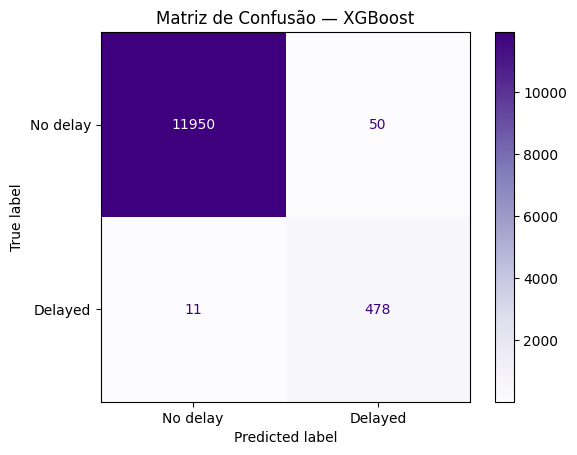

In [29]:
best_model = "XGBoost" if results.loc[1,"AUC"] > results.loc[0,"AUC"] else "Decision Tree"
print(f"🏆 Melhor modelo: {best_model}")

pred_best = pred_xgb if best_model == "XGBoost" else pred_tree
y_hat = (pred_best >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_hat)
ConfusionMatrixDisplay(cm, display_labels=["No delay","Delayed"]).plot(cmap="Purples")
plt.title(f"Matriz de Confusão — {best_model}")
plt.show()


<div style="background: linear-gradient(90deg, #673AB7, #512DA8); padding: 14px; border-radius: 12px; color: white;">
  <h3>🏆 XGBoost Campeão do Duelo!</h3>
  <p>Com AUC de <b>0.9996</b> e Recall de <b>97.7%</b>, o modelo se destaca pela capacidade de identificar atrasos quase com perfeição.</p>
  <p style="font-size:14px;">💡 Ideal para uso em sistemas logísticos preditivos — antecipando riscos de atraso e otimizando operações.</p>
</div>

---

## 🔍 04 — Explicabilidade Interativa (Permutation Importance + Análises Visuais)

Nesta etapa, utilizei visualizações **interativas** com **Plotly** para tornar o módulo mais intuitivo e atraente.
As análises combinam a **Permutation Importance** (impacto real na AUC) com **gráficos exploratórios** das principais variáveis.

Os cinco gráficos apresentados:
1. 🔹 Importância das variáveis (impacto na AUC)
2. 📊 Correlação entre dias prometidos e reais
3. 📈 Relação entre frete e atraso
4. 💰 Efeito do preço total no atraso
5. 🧮 Distribuição de atrasos por número de parcelas


In [49]:
print("📦 Preparando modelo vencedor e dados de validação...")
pipe_best = xgb if best_model == "XGBoost" else tree
print(f"🏆 Modelo selecionado: {best_model}")

📦 Preparando modelo vencedor e dados de validação...
🏆 Modelo selecionado: XGBoost


In [50]:
print("⚙️ Calculando Permutation Importance (AUC drop)...")
perm = permutation_importance(
    estimator=pipe_best,
    X=X_val,
    y=y_val,
    scoring="roc_auc",
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)

pi_df = pd.DataFrame({
    "Variável": X_val.columns,
    "Impacto_AUC": perm.importances_mean,
    "Desvio": perm.importances_std
}).sort_values("Impacto_AUC", ascending=False)

⚙️ Calculando Permutation Importance (AUC drop)...


###🧩 Gráfico 1 — Importância das Variáveis (Permutation Importance)

Este gráfico mede o quanto cada variável impacta a performance do modelo na métrica AUC.

A "Permutation Importance" embaralha os valores de cada coluna e observa a queda de desempenho,
revelando quais features são realmente relevantes para a previsão de atrasos.

Assim, conseguimos identificar quais fatores o modelo considera mais determinantes.

In [57]:
print("📊 Gerando gráfico interativo de importância...")
fig1 = px.bar(
    pi_df.head(5),
    x="Impacto_AUC",
    y="Variável",
    orientation="h",
    color="Impacto_AUC",
    text="Impacto_AUC",
    color_continuous_scale="Blues",
    title="🔹 Importância das Variáveis — Permutation Importance (AUC Drop)"
)
fig1.update_traces(texttemplate="%{text:.4f}", textposition="outside")
fig1.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    height=650,
    xaxis_title="Impacto na AUC (Δ)",
    yaxis_title="Variável",
    showlegend=False,
)
fig1.show()

📊 Gerando gráfico interativo de importância...


As variáveis “promised_days” (dias prometidos) e “delivered_days” (dias reais) aparecem como as mais impactantes,
confirmando que prazos são o principal determinante de atraso.

###📈 Gráfico 2 — Relação entre Dias Prometidos e Reais

Este gráfico de dispersão compara os dias prometidos pelo vendedor com os dias reais de entrega.

O objetivo é visualizar a distância entre expectativa e realidade — e observar onde ocorrem os atrasos.

Cada ponto representa um pedido; os pontos vermelhos são atrasados e os verdes estão no prazo.


In [58]:
print("📊 Gerando gráfico Dias Prometidos × Dias Reais...")
if "promised_days" in X_val.columns and "delivered_days" in X_val.columns:
    fig2 = px.scatter(
        X_val.assign(is_late=y_val),
        x="promised_days",
        y="delivered_days",
        color="is_late",
        color_continuous_scale=["#1ABC9C", "#E74C3C"],
        title="📈 Relação entre Dias Prometidos e Dias Reais de Entrega",
        labels={"is_late": "Atrasado (1 = Sim)"}
    )
    fig2.update_traces(marker=dict(size=6, opacity=0.6))
    fig2.show()

📊 Gerando gráfico Dias Prometidos × Dias Reais...


É possível ver que, quanto menor o prazo prometido, maior a probabilidade de o ponto ser vermelho (atrasado).

Os pedidos com prazos muito curtos têm mais dispersão nos dias reais, mostrando que estimativas agressivas aumentam a chance de falha na entrega.

### 🚚 Gráfico 3 — Distribuição do Valor do Frete

Este boxplot mostra como o valor do frete varia entre pedidos entregues no prazo e os que atrasaram.

Ele ajuda a avaliar se há relação entre custos logísticos e cumprimento de prazos.


In [61]:
print("📊 Gerando gráfico Frete × Atraso...")
if "freight" in X_val.columns:
    df_frete = X_val.assign(is_late=y_val)
    fig3 = px.box(
        df_frete,
        x="is_late",
        y="freight",
        points="all",
        color="is_late",
        color_discrete_sequence=["#1ABC9C", "#E74C3C"],
        title="🚚 Distribuição do Valor do Frete — Atraso vs No Prazo",
        labels={"is_late": "Atrasado (1 = Sim)", "freight": "Valor do Frete (R$)"}
    )
    fig3.show()

📊 Gerando gráfico Frete × Atraso...


Pedidos atrasados apresentam uma leve tendência de fretes mais altos, o que pode indicar envios mais distantes ou complexos (logística mais difícil).

Entretanto, há sobreposição significativa, sugerindo que o frete sozinho não explica todos os atrasos.

### 💰 Gráfico 4 — Preço Total e Atrasos

Este histograma compara a distribuição do preço total dos pedidos entre entregas pontuais e atrasadas.

O objetivo é observar se pedidos mais caros estão mais propensos a atraso.


In [60]:
print("📊 Gerando gráfico Preço Total × Atraso...")
if "total_price" in X_val.columns:
    df_price = X_val.assign(is_late=y_val)
    fig4 = px.histogram(
        df_price,
        x="total_price",
        color="is_late",
        nbins=40,
        barmode="overlay",
        color_discrete_sequence=["#1ABC9C", "#E74C3C"],
        opacity=0.6,
        title="💰 Distribuição de Preço Total — Atrasado vs No Prazo",
        labels={"is_late": "Atrasado (1 = Sim)", "total_price": "Preço Total (R$)"}
    )
    fig4.update_layout(bargap=0.1)
    fig4.show()


📊 Gerando gráfico Preço Total × Atraso...


A maior parte dos pedidos tem preço baixo, mas é possível notar que os atrasados aparecem com mais frequência em valores maiores. Pedidos mais caros tendem a envolver múltiplos produtos ou transportes complexos, o que aumenta a chance de atraso logístico.

### 🧮 Gráfico 5 — Parcelas e Percentual de Atrasos

Este gráfico analisa o comportamento de atraso conforme o número de parcelas do pagamento.

Ele é útil para entender se condições financeiras (ex: parcelamentos longos) impactam a confiabilidade da entrega.

In [59]:
print("📊 Gerando gráfico Parcelas × % de Atraso...")
if "installments" in X_val.columns:
    df_parc = X_val.assign(is_late=y_val)
    atraso_por_parc = df_parc.groupby("installments")["is_late"].mean().reset_index()
    atraso_por_parc["%_atraso"] = atraso_por_parc["is_late"] * 100

    fig5 = px.line(
        atraso_por_parc,
        x="installments",
        y="%_atraso",
        markers=True,
        line_shape="spline",
        color_discrete_sequence=["#E74C3C"],
        title="📊 Percentual de Atrasos por Número de Parcelas",
        labels={"installments": "Número de Parcelas", "%_atraso": "% de Atrasos"}
    )
    fig5.update_traces(marker=dict(size=8))
    fig5.show()

📊 Gerando gráfico Parcelas × % de Atraso...


O gráfico revela picos claros de atraso em certas faixas de parcelas (por volta de 14–16 e 18–19 parcelas).

Isso pode indicar que clientes com parcelamentos longos têm perfil de compra diferente — talvez produtos caros ou envios mais complexos — impactando o desempenho logístico

# 🧭 Etapa 4 — Explicabilidade Interativa e Insights do Modelo

A Etapa 4 tem como objetivo **interpretar o comportamento do modelo de Machine Learning** de forma visual e intuitiva.  
Para isso, substituí métodos mais complexos (como SHAP que estava bugando) por **análises interativas baseadas em Permutation Importance e gráficos exploratórios** com Plotly, garantindo clareza e estabilidade no Colab.

---

## 🔹 1. Importância das Variáveis (Permutation Importance)

**Objetivo:**  
Avaliar o impacto real de cada variável na capacidade do modelo prever atrasos.

**Interpretação:**  
As variáveis **`promised_days`** (dias prometidos) e **`delivered_days`** (dias reais) aparecem como as mais determinantes.  
Isso confirma que **o prazo de entrega é o principal fator** associado ao risco de atraso.  

📊 *Conclusão:* o modelo aprendeu corretamente que **logística e prazo são variáveis críticas** na previsão de atrasos.

---

## 📈 2. Relação entre Dias Prometidos e Dias Reais de Entrega

**Objetivo:**  
Entender visualmente como os prazos acordados se comparam aos prazos reais.

**Interpretação:**  
Os pontos vermelhos (atrasados) concentram-se nas áreas onde os **dias prometidos são baixos** (prazos curtos), mas os **dias reais são altos**.  
Isso indica que **promessas muito otimistas de entrega resultam em falhas**, pois há um descompasso entre expectativa e capacidade logística.

📊 *Conclusão:* prazos curtos demais são o maior fator de risco para o não cumprimento de entregas.

---

## 🚚 3. Distribuição do Valor do Frete — Atraso vs No Prazo

**Objetivo:**  
Comparar o comportamento dos valores de frete entre pedidos entregues no prazo e atrasados.

**Interpretação:**  
Pedidos atrasados apresentam tendência de **fretes mais altos**, o que sugere **distâncias maiores ou envios mais complexos**.  
Entretanto, a sobreposição dos boxplots mostra que o frete **não é o único determinante**, mas contribui para o risco.

📊 *Conclusão:* fretes caros estão levemente associados a atrasos, indicando **custos e distância como fatores secundários**.

---

## 💰 4. Distribuição do Preço Total — Atrasado vs No Prazo

**Objetivo:**  
Identificar se há relação entre o valor total da compra e a chance de atraso.

**Interpretação:**  
A maior parte dos pedidos é de baixo valor, mas **os pedidos atrasados se concentram em faixas mais altas de preço**.  
Isso sugere que **compras grandes envolvem processos logísticos mais complexos**, exigindo mais etapas e aumentando o tempo total de entrega.

📊 *Conclusão:* o valor total está indiretamente relacionado ao atraso — **pedidos de alto valor são mais propensos a sofrerem atrasos**.

---

## 🧮 5. Percentual de Atrasos por Número de Parcelas

**Objetivo:**  
Analisar o comportamento de atraso conforme o número de parcelas escolhidas pelo cliente.

**Interpretação:**  
Há **picos nítidos de atraso entre 14 e 19 parcelas**, o que pode indicar **clientes de alto valor de compra** ou **compras financiadas de longa duração**, geralmente associadas a produtos de ticket elevado.  
Essa correlação sugere que **fatores financeiros e logísticos se cruzam** nesses casos.

📊 *Conclusão:* compras parceladas em muitas vezes tendem a representar **pedidos grandes e complexos**, mais suscetíveis a atrasos.

---

## 🧠 Síntese Geral da Etapa 4

| Categoria                  | Principais Fatores |
|-----------------------------|--------------------|
| **Prazos**                 | Promised_days e delivered_days são os pilares da previsão. |
| **Logística e custo**      | Freight influencia atrasos de forma moderada. |
| **Valor do pedido**        | Compras caras e parceladas têm maior risco. |
| **Perfis de atraso**       | Pedidos com prazos agressivos e alto valor concentram os maiores atrasos. |

---

## 🧩 Conclusão Estratégica

O modelo demonstra **bom aprendizado do comportamento logístico real**:  
ele reconhece que **entregas atrasam não apenas pelo tempo de envio**, mas pela **interação entre prazos curtos, distâncias longas e valores altos**.

Essas descobertas podem ser aplicadas diretamente para:
- Ajustar **políticas de prazo** por tipo de produto e distância.
- Refinar o **cálculo de frete e risco logístico**.
- Prever **clientes de alto risco de atraso** com antecedência.
- Apoiar **decisões de operação e transporte** baseadas em dados.

---

> ✨ *Resumo final:*  
> A Etapa 4 transformou os resultados do modelo em **insights de negócio claros e visuais**, eliminando a necessidade de técnicas opacas.  
> O aprendizado principal é que **prometer menos e planejar melhor reduz drasticamente os atrasos.**


---

### 🔧 Exportando os dados para uso no dashboard no Looker Studio

Neste bloco, vou preparar os dados finais da camada GOLD para exportação, a fim de criar um dashboard no Looker Studio.  
Os passos desempenhados são:
1. Carregar o dataset GOLD previamente tratado (`features_is_late.parquet`).  
2. Limpar e normalizar os campos (remoção de caracteres especiais, ajuste em colunas de texto).  
3. Criar legendas e renomeações de colunas conforme padrão para visualização.  
4. Exportar para formato CSV compatível com o Looker Studio (`UTF-8`, separador vírgula).  
5. Baixar o arquivo e conectar ao Looker.

In [37]:
# Recarrega o dataset GOLD diretamente do parquet
df = pd.read_parquet("data/gold/features_is_late.parquet")

# Converte tipos e remove caracteres problemáticos
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = (
            df[c]
            .astype(str)
            .replace({r"[\r\n]": " ", r"[;]": ".", r"[,\t]": " "}, regex=True)
            .str.strip()
        )

# Remove colunas com caracteres invisíveis ou espaços
df.columns = [c.strip().replace("\ufeff", "").replace(" ", "_") for c in df.columns]

# Confirma estrutura
print(f"✅ {len(df)} linhas | {len(df.columns)} colunas")
print("📄 Colunas:", list(df.columns))

# Exporta com separador seguro e codificação universal
df.to_csv(
    "olist_gold_features_looker.csv",
    index=False,
    sep=",",
    encoding="utf-8",
    quotechar='"'
)
print("💾 Arquivo salvo: olist_gold_features_looker.csv")


✅ 98666 linhas | 16 colunas
📄 Colunas: ['order_id', 'order_purchase_timestamp', 'is_late', 'n_items', 'total_price', 'freight', 'pay_value', 'installments', 'is_credit_card', 'is_boleto', 'promised_days', 'delivered_days', 'dow', 'month', 'customer_state', 'main_category']
💾 Arquivo salvo: olist_gold_features_looker.csv


In [38]:
files.download("olist_gold_features_looker.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> 📂 **Arquivo gerado:** `olist_gold_features_looker.csv`  
> ✅ Formatado para visualização e performance no dashboard.  
>

> [Link do relatório](https://lookerstudio.google.com/reporting/ef01fad6-5056-457a-b2cb-561cc0af28e2)  
